<a href="https://colab.research.google.com/github/HamzaMPSY/AI-Projects/blob/master/ageGenderPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
pip install keras-metrics

In [ ]:
%tensorflow_version 1.x
import numpy as np
import os 
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model,Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.models import model_from_json
from keras import regularizers,metrics
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_metrics as km

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
def coefficient(I, k):
    return 1 / (1 + ((I / k) ** 2))


def anisotropic_diffusion(image, iterations, k, lamb=0.01):
    
    new_image = np.zeros(image.shape, dtype=image.dtype)

    for t in range(iterations):
        I_North = image[:-2, 1:-1] - image[1:-1, 1:-1]
        I_South = image[2:, 1:-1] - image[1:-1, 1:-1]
        I_East = image[1:-1, 2:] - image[1:-1, 1:-1]
        I_West = image[1:-1, :-2] - image[1:-1, 1:-1]

        new_image[1:-1, 1:-1] = image[1:-1, 1:-1] + lamb * (
            coefficient(I_North, k) * I_North +
            coefficient(I_South, k) * I_South +
            coefficient(I_East, k) * I_East +
            coefficient(I_West, k) * I_West
        )

        image = new_image
    return image

In [ ]:
img = cv2.imread('gender_age_classification/test/rsz_hamza9.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(160,160))
plt.imshow(img)
plt.show()
img  = anisotropic_diffusion(img, iterations=10, k=0.5)
plt.imshow(img)
plt.show()

In [ ]:
def getData():
  images = []
  ages = []
  genders = []
  d = 'crop_part1/crop_part1'
  for i,pic in enumerate(os.listdir(d)):
    if i % 100 == 0:
      print(i)
    img = cv2.imread(d + '/' +pic)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(160,160))
    img  = anisotropic_diffusion(img, iterations=50, k=0.5)
    images.append(img)
    
  images= np.array(images)
  np.save('utkfacesdata_160_ani.npy',images)

In [ ]:
getData()

In [ ]:
def loadModel_160():
	model_path = 'facenet/facenet_keras.h5'
	model = load_model(model_path)
	model.load_weights('facenet/facenet_keras_weights.h5')
	return model

def loadModel():
	json_file = open('encoder_mpsy.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	loaded_model = model_from_json(loaded_model_json)
	# load weights into new model
	loaded_model.load_weights("encoder_mpsy.h5")
	print("Loaded model from disk")
	return loaded_model


In [ ]:
mpsy = loadModel()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loaded model from disk


In [ ]:
images = np.load('utkfacesdata_160_ani.npy')

In [ ]:
images = images/255.

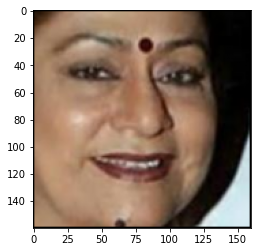

In [ ]:
plt.imshow(images[0,...])

In [ ]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
	"""
	function that normalize an np.array 
	"""
	output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
	return output

def preprocess(x):
	"""
	function to preprocess an image or array of images
	"""
	if x.ndim == 4:
	    axis = (1, 2, 3)
	    size = x[0].size
	elif x.ndim == 3:
	    axis = (0, 1, 2)
	    size = x.size
	else:
	    raise ValueError('Dimension should be 3 or 4')

	mean = np.mean(x, axis=axis, keepdims=True)
	std = np.std(x, axis=axis, keepdims=True)
	std_adj = np.maximum(std, 1.0/np.sqrt(size))
	y = (x - mean) / std_adj
	return y

In [ ]:
for i in range(images.shape[0]):
  images[i,...] = preprocess(images[i,...])

In [ ]:
embeeds = mpsy.predict(images)

In [ ]:
embeeds.shape

(8528, 128)

In [ ]:
np.save('utkfacesembeeds_160_mpsy_ani.npy',embeeds)

In [ ]:
def createAgeModel(layers):
  inp  = Input((128,))
  x = Dense(layers[0],activation='relu')(inp)
  x = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  for layer in layers[1:]:
    x = Dense(layer,activation='relu')(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
  out = Dense(1,name='age') (x)
  model = Model(inp,out)
  model.compile(loss="mae", optimizer='adam',metrics=[metrics.MeanAbsoluteError(name='age_mae')])
  
  return model

def createGenderModel(layers):
  inp  = Input((128,))
  x = Dense(layers[0],activation='relu')(inp)
  #x = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  for layer in layers[1:]:
    x = Dense(layer,activation='relu')(x)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
  out = Dense(2,activation='softmax',name='gender')(x)
  model = Model(inp,out)
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy',km.categorical_precision(),km.sparse_categorical_recall(),km.categorical_f1_score()])
  
  return model


In [ ]:
plot_model(model)

In [ ]:
embeeds = np.load('utkfacesembeeds_160_mpsy_ani.npy')
ages = np.load('utkages.npy')
genders = np.load('utkgenders.npy')

embeeds = embeeds[genders!=3]
ages = ages[genders!=3]
genders = genders[genders!=3]

In [ ]:
genders= to_categorical(genders)
genders.shape

(8527, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeeds,ages, test_size=0.2)

In [ ]:
model = createAgeModel([256,128,64,32,16])
batch_size = 64
epochs = 100
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs, batch_size=batch_size)

In [ ]:
models = np.load('models_result_mpsy_ani.npy')
models.shape

(6, 1706, 2)

In [ ]:
np.save('y_test_mpsy_ani.npy',y_test)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
models = np.load('models_result_ani.npy')
y_test_keras = np.argmax(y_test,axis = 1)
fpr = []
tpr = []
aucc = []

for i in range(models.shape[0]):
  y_pred_keras = np.argmax(models[i,...],axis = 1)

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_keras, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  fpr.append(fpr_keras)
  tpr.append(tpr_keras)
  aucc.append(auc_keras)


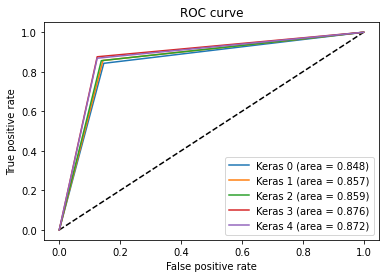

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(len(fpr)):
  plt.plot(fpr[i], tpr[i], label='Keras '+str(i)+' (area = {:.3f})'.format(aucc[i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

rsz_hamza9.jpg
rsz_hamza1 (1).jpg
rsz_outhmane7.jpg
rsz_outhmane2.jpg
rsz_193586ea523e9527f4e89a8cffd8f926.jpg
[23.912748]
[25.113977]
[25.017187]
[29.540781]
[19.165678]


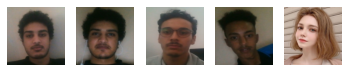

In [ ]:
import matplotlib.pyplot as plt
images = []

for pic in os.listdir('gender_age_classification/test'):
  print(pic)
  img = cv2.imread('gender_age_classification/test/'+pic)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(160,160))
  images.append(img)

images= np.array(images)
images= images/255.

# images = np.load('utkfacesdata.npy')
# images = images[0:5]
# yp = y[0:5]
test = facenet.predict(images)
y = model.predict(test)


fig = plt.figure()
for i in range(images.shape[0]):
    img = images[i].squeeze()
    sub = fig.add_subplot(1, images.shape[0], i+1)
    sub.axis('off')        
    sub.imshow(img)
    print(y[i])

In [ ]:
# serialize classifier to JSON
classifier_json = model.to_json()
with open("model_age_gender.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
model.save_weights("model_age_gender.h5")
print("Saved classifier to disk")

Saved classifier to disk


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(3)
X = pca.fit_transform(embeeds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:,0], X[:,1],c=genders)
#legend1 = fig.legend(*scatter.legend_elements(), title="ages",loc='lower center')
legend1 = ax.legend(*scatter.legend_elements(),title="genders",loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.show()

In [ ]:
embds = model.predict(images)
embds = 

In [ ]:
from scipy.spatial import distance

In [ ]:
distance.euclidean(embds[1], embds[2])

5.004965782165527

In [ ]:
images_ani = np.load('utkfacesdata_160_ani.npy')/255.
images =np.transpose(np.load('utkfacesdata_160.npy'),(0,2,3,1))

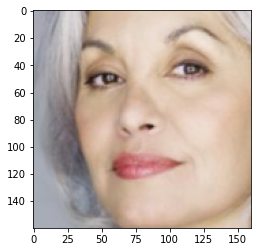

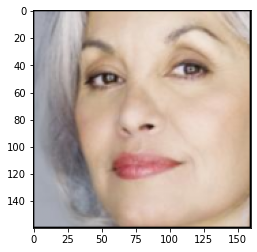

In [ ]:
plt.imshow(images[153,...])
plt.show()
plt.imshow(images_ani[153,...])
plt.show()